# Importings

In [64]:
# Importing basic stuff
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Train test split
from sklearn.model_selection import train_test_split

# LDA
from sklearn.decomposition import LatentDirichletAllocation

# Preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

# evaluation
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Gridsearch
from sklearn.model_selection import GridSearchCV

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Reading data and making it available for analysis

In [2]:
# Naming the columns of the dataset. https://stackoverflow.com/questions/31645466/give-column-name-when-read-csv-file-pandas
colNames = ['polarity', 'title', 'text']

# Loading Dataset and assigning column names
df = pd.read_csv("./data/test.csv", names=colNames, header=None)

# Resizing the dataset, for faster computing time. A random sample from the dataset https://stackoverflow.com/questions/40986230/reduce-dataframe-size-in-pandas
df = df.sample(frac=0.1) # Get 10% of the data

In [3]:
# Looking on the data
(
    df
    #.sample(5)
    #.dtypes
    .info()
    #.loc[:,["polarity"]]
    #.loc[:,["title"]]
    #.loc[:,["text"]]
    #.value_counts()
    #.value_counts(normalize=True) # For seeing the count in %
    #.describe()
)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 355831 to 118180
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   polarity  40000 non-null  int64 
 1   title     39999 non-null  object
 2   text      40000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [4]:
# Cleaning the data. Removing null values and only take the values that contain info.
# https://stackoverflow.com/questions/13413590/how-to-drop-rows-of-pandas-dataframe-whose-value-in-a-certain-column-is-nan
df.dropna(how='any')
df = df[df['title'].notna()]
df = df[df['text'].notna()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39999 entries, 355831 to 118180
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   polarity  39999 non-null  int64 
 1   title     39999 non-null  object
 2   text      39999 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [5]:
# Assigning values to X and Y
xText = df.text
xTitle = df.title
y = df.polarity

xText.head(1)

355831    Loved this version the first time I saw it. Th...
Name: text, dtype: object

In [6]:
# Train test split of data. Putting O at the end of the X variables for "original"
X_train, X_test, y_train, y_test = train_test_split(xText, y, test_size=0.33, random_state=42)

In [7]:
# Looking on one example
print("type of X_train: {}".format(type(X_train)))
print("length of X_train: {}".format(len(X_train)))
print("X_train[1]:\n{}".format(X_train.iloc[1500]))

type of X_train: <class 'pandas.core.series.Series'>
length of X_train: 26799
X_train[1]:
There's no denying that Taylor is a very good writer of short stories, but this selection will not do, for the serious reader, scholar, or intrigued novice. There is no documentation whatsoever! One does not know, for example, when these stories were written, where they were first published, who made the selection and on what basis. The last complaint is made even more egregious by the misleading title: this book does not "collect" all of Taylor's stories. Certainly, a preface or introduction would have been helpful. And what's with the photo of a southern plantation on the cover? These stories are set in a post-bellum, mostly urban South. Peter Taylor deserves better than this shoddy, sloppy presentation. So do his readers.


# Basics - Countvectorizer plus logistic regression

In [8]:
# Applying Count vectorizer
vect = CountVectorizer()
vect.fit(X_train)
X_trainB = vect.transform(X_train)
X_testB = vect.transform(X_test)


In [9]:
# Looking on the vectorized features. See page 331 for code
feature_names = vect.get_feature_names_out() # under methods: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
print("Number of features: {}".format(len(feature_names)))
print("First 20 features:\n{}".format(feature_names[:20]))
print("Features 20010 to 20030:\n{}".format(feature_names[20010:20030]))
print("Every 2000th feature:\n{}".format(feature_names[::2000]))

Number of features: 55899
First 20 features:
['00' '000' '0000' '00001' '0001' '000hz' '000th' '001' '002' '004' '006'
 '007' '008' '009' '00am' '01' '010' '016' '02' '03']
Features 20010 to 20030:
['folly' 'folowing' 'fom' 'fond' 'fonda' 'fondest' 'fondle' 'fondly'
 'fondness' 'fondue' 'fondues' 'fonkifying' 'fonsecaeditor' 'font' 'fonts'
 'foo' 'food' 'foodie' 'foods' 'foodsaver']
Every 2000th feature:
['00' 'actually' 'arkansaw' 'berlioz' 'busting' 'civility' 'cosistently'
 'derailed' 'dudly' 'evoke' 'follow' 'gram' 'hochschild' 'instrucctivos'
 'klien' 'lure' 'ministers' 'nitrogen' 'paragraphs' 'portends' 'randolph'
 'riff' 'selves' 'sog' 'sucess' 'thradon' 'underskirt' 'washes']


In [10]:
# Making a logistic regression model
BaseLR = LogisticRegression(max_iter=10000)

# Fitting the model
BaseLR.fit(X_trainB, y_train)


LogisticRegression(max_iter=10000)

In [11]:
# Evaluating results
y_pred = BaseLR.predict(X_testB)

# Printing classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.86      0.84      0.85      6673
           2       0.84      0.85      0.85      6527

    accuracy                           0.85     13200
   macro avg       0.85      0.85      0.85     13200
weighted avg       0.85      0.85      0.85     13200



In [12]:
# Confusion matrix
# Making a confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[5631 1042]
 [ 947 5580]]


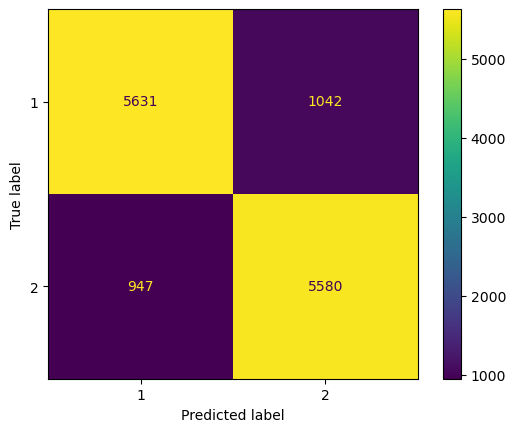

In [13]:
# Displaying confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=BaseLR.classes_)
disp.plot()
plt.show()

## Dummy classifier

# Sentiment analysis

## Predefinings

In [8]:
# Predefined Standard variables for countvectorizer and TfidTransformer
ngram_range = [(1,1),(1,2)]
use_idf = [True,False]

## Logistic Regression

In [11]:
# Pipeline for Logistic Regression
pipeLR = Pipeline(steps=[
    ('CountVectorizer',CountVectorizer()),
    ('TfidfTransformer',TfidfTransformer()),
    ('Model', LogisticRegression(max_iter=10000))
])

# Fitting the pipeline with data
pipeLR.fit(X_train, y_train)

Pipeline(steps=[('CountVectorizer', CountVectorizer()),
                ('TfidfTransformer', TfidfTransformer()),
                ('Model', LogisticRegression(max_iter=10000))])

In [12]:
# Printing scores
print("Accuracy on training set: {:.3f}".format(pipeLR.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(pipeLR.score(X_test, y_test)))

Accuracy on training set: 0.908
Accuracy on test set: 0.857


In [14]:
# Pipeline together with gridsearchCV: https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html
# Defining parameters for the param grid
params = {
    'CountVectorizer__ngram_range':ngram_range,
    'TfidfTransformer__use_idf':use_idf,
    'Model__C':[0.01, 0.1, 1, 10, 100],
    'Model__max_iter':[10000]
}

# Defining grid search
searchLR = GridSearchCV(
    pipeLR,
    param_grid=params,
    cv=2,
    verbose = 1.5 # To track the progress
)

# Fitting the grid search
searchLR.fit(X_train, y_train)

Fitting 2 folds for each of 20 candidates, totalling 40 fits
[CV] END CountVectorizer__ngram_range=(1, 1), Model__C=0.01, Model__max_iter=10000, TfidfTransformer__use_idf=True; total time=   1.8s
[CV] END CountVectorizer__ngram_range=(1, 1), Model__C=0.01, Model__max_iter=10000, TfidfTransformer__use_idf=True; total time=   1.8s
[CV] END CountVectorizer__ngram_range=(1, 1), Model__C=0.01, Model__max_iter=10000, TfidfTransformer__use_idf=False; total time=   1.7s
[CV] END CountVectorizer__ngram_range=(1, 1), Model__C=0.01, Model__max_iter=10000, TfidfTransformer__use_idf=False; total time=   1.7s
[CV] END CountVectorizer__ngram_range=(1, 1), Model__C=0.1, Model__max_iter=10000, TfidfTransformer__use_idf=True; total time=   2.0s
[CV] END CountVectorizer__ngram_range=(1, 1), Model__C=0.1, Model__max_iter=10000, TfidfTransformer__use_idf=True; total time=   1.7s
[CV] END CountVectorizer__ngram_range=(1, 1), Model__C=0.1, Model__max_iter=10000, TfidfTransformer__use_idf=False; total time=  

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('CountVectorizer', CountVectorizer()),
                                       ('TfidfTransformer', TfidfTransformer()),
                                       ('Model',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'CountVectorizer__ngram_range': [(1, 1), (1, 2)],
                         'Model__C': [0.01, 0.1, 1, 10, 100],
                         'Model__max_iter': [10000],
                         'TfidfTransformer__use_idf': [True, False]},
             verbose=1.5)

In [19]:
# Printing results
print("Accuracy on training set: {:.3f}".format(searchLR.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(searchLR.score(X_test, y_test)))
print("Best params: ", searchLR.best_params_) # Printing the best params

Accuracy on training set: 1.000
Accuracy on test set: 0.886
Best params:  {'CountVectorizer__ngram_range': (1, 2), 'Model__C': 100, 'Model__max_iter': 10000, 'TfidfTransformer__use_idf': True}
Best params:  0.869920477469359


## MLP

In [30]:
# Defining pipe for MLP
pipeMLP = Pipeline(steps=[
    ('CountVectorizer',CountVectorizer()),
    ('TfidfTransformer',TfidfTransformer()),
    ('Model', MLPClassifier())
])

# Fitting the pipeline with the data
pipeMLP.fit(X_train, y_train)

Pipeline(steps=[('CountVectorizer', CountVectorizer()),
                ('TfidfTransformer', TfidfTransformer()),
                ('Model', MLPClassifier())])

In [31]:
# Printing scores on the simple version of the model
print("Accuracy on training set: {:.3f}".format(pipeMLP.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(pipeMLP.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.822


In [ ]:
# Defining parameters for the param grid. Very intensive when it comes to computing time
params = {
    'CountVectorizer__ngram_range':ngram_range,
    'TfidfTransformer__use_idf':use_idf,
    'Model__activation':['tanh','relu'],
    #'Model__solver':['lbfgs'],
    'Model__hidden_layer_sizes':[50,100],
    'Model__max_iter':[10000]
}

# Defining grid search with the pipeline
searchMLP = GridSearchCV(
    pipeMLP,
    param_grid=params,
    cv=2,
    verbose = 1.5
)

# Fitting the grid search
searchMLP.fit(X_train, y_train)

In [ ]:
# Printing results for MLP
print("Accuracy on training set: {:.3f}".format(searchMLP.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(searchMLP.score(X_test, y_test)))
print("Best params: ", searchMLP.best_params_) # Printing the best params

## Naive Bayes

In [20]:
# Defining pipe for Naive Bayes
pipeNB = Pipeline(steps=[
    ('CountVectorizer',CountVectorizer()),
    ('TfidfTransformer',TfidfTransformer()),
    ('Model', MultinomialNB())
])

# Fitting the pipeline with the data
pipeNB.fit(X_train, y_train)

Pipeline(steps=[('CountVectorizer', CountVectorizer()),
                ('TfidfTransformer', TfidfTransformer()),
                ('Model', MultinomialNB())])

In [21]:
# Printing scores on the simple version of the model
print("Accuracy on training set: {:.3f}".format(pipeNB.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(pipeNB.score(X_test, y_test)))

Accuracy on training set: 0.894
Accuracy on test set: 0.817


In [22]:
# Defining parameters for the param grid
params = {
    'CountVectorizer__ngram_range':ngram_range,
    'TfidfTransformer__use_idf':use_idf,
    'Model__alpha':[1] # other parameters to be defined
}

# Defining grid search with the pipeline
searchNB = GridSearchCV(
    pipeNB,
    param_grid=params,
    cv=2
)

# Fitting the grid search
searchNB.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('CountVectorizer', CountVectorizer()),
                                       ('TfidfTransformer', TfidfTransformer()),
                                       ('Model', MultinomialNB())]),
             param_grid={'CountVectorizer__ngram_range': [(1, 1), (1, 2)],
                         'Model__alpha': [1],
                         'TfidfTransformer__use_idf': [True, False]})

In [23]:
# Printing results for MultinominalNB
print("Accuracy on training set: {:.3f}".format(searchNB.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(searchNB.score(X_test, y_test)))
print("Best params: ", searchNB.best_params_) # Printing the best params

Accuracy on training set: 0.967
Accuracy on test set: 0.856
Best params:  {'CountVectorizer__ngram_range': (1, 2), 'Model__alpha': 1, 'TfidfTransformer__use_idf': True}


## Random Forrest

In [24]:
# Defining pipe for Random Forrest
pipeRF = Pipeline(steps=[
    ('CountVectorizer',CountVectorizer()),
    ('TfidfTransformer',TfidfTransformer()),
    ('Model', RandomForestClassifier())
])

# Fitting the pipeline with the data
pipeRF.fit(X_train, y_train)

Pipeline(steps=[('CountVectorizer', CountVectorizer()),
                ('TfidfTransformer', TfidfTransformer()),
                ('Model', RandomForestClassifier())])

In [25]:
# Printing scores on the simple version of the model
print("Accuracy on training set: {:.3f}".format(pipeRF.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(pipeRF.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.822


In [26]:
# Defining parameters for the param grid
params = {
    'CountVectorizer__ngram_range':ngram_range,
    'TfidfTransformer__use_idf':use_idf,
    'Model__n_estimators':[50,100,150], # other parameters to be defined
    'Model__max_depth':[5,10],
    'Model__min_samples_leaf':[5,10],
    'Model__random_state':[42]
}

# Defining grid search with the pipeline
searchRF = GridSearchCV(
    pipeRF,
    param_grid=params,
    cv=2,
)

# Fitting the grid search
searchRF.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('CountVectorizer', CountVectorizer()),
                                       ('TfidfTransformer', TfidfTransformer()),
                                       ('Model', RandomForestClassifier())]),
             param_grid={'CountVectorizer__ngram_range': [(1, 1), (1, 2)],
                         'Model__max_depth': [5, 10],
                         'Model__min_samples_leaf': [5, 10],
                         'Model__n_estimators': [50, 100, 150],
                         'Model__random_state': [42],
                         'TfidfTransformer__use_idf': [True, False]})

In [27]:
# Printing results for Random Forrest
print("Accuracy on training set: {:.3f}".format(searchRF.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(searchRF.score(X_test, y_test)))
print("Best params: ", searchRF.best_params_) # Printing the best params

Accuracy on training set: 0.821
Accuracy on test set: 0.795
Best params:  {'CountVectorizer__ngram_range': (1, 2), 'Model__max_depth': 10, 'Model__min_samples_leaf': 10, 'Model__n_estimators': 150, 'Model__random_state': 42, 'TfidfTransformer__use_idf': True}


## Summarizing

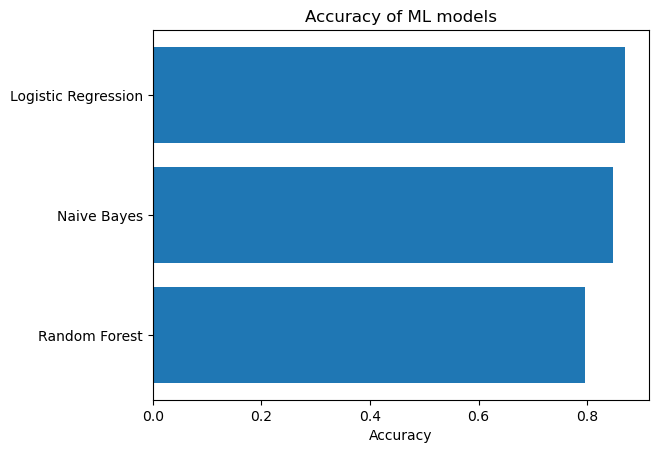

In [47]:
# Plotting the different accuracies and comparing them Got help from Chat GPT with this prompt: 
# "I have the following ML models where i want to plot the accuracy of each starting with the one with the highest accuracy:searchLR searchMLP searchNB searchRF"

# accuracy values in descending order
accuracies = [searchRF.best_score_, searchNB.best_score_, searchLR.best_score_]

# model names in the same order as accuracies
model_names = ["Random Forest", "Naive Bayes", "Logistic Regression"]

# plot horizontal bar chart
plt.barh(model_names, accuracies)

# add axis labels and title
plt.xlabel("Accuracy")
plt.title("Accuracy of ML models")

# show plot
plt.show()

In [ ]:
# Got help from ChatGpt here, following the same conversation as in the codeblock from above
# accuracy values on test set in descending order
accuracies = [searchRF.best_estimator_.score(X_test, y_test),
              searchMLP.best_estimator_.score(X_test, y_test),
              searchNB.best_estimator_.score(X_test, y_test),
              searchLR.best_estimator_.score(X_test, y_test)]

# model names in the same order as accuracies
model_names = ["Random Forest", "MLP", "Naive Bayes", "Logistic Regression"]

# plot horizontal bar chart
plt.barh(model_names, accuracies)

# add axis labels and title
plt.xlabel("Accuracy on test set")
plt.title("Accuracy of ML models on test set")

# show plot
plt.show()

# Topic Categorization

## Latent Dirichlet Allocation

In [48]:
# Using CountVectorizer, as in the other models that have been built
vectLDA = CountVectorizer(max_df=.15, min_df=5)
X_trainLDA = vectLDA.fit_transform(X_train)

In [58]:
# See page 349 in the book, and https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
# Number of topics default is 10 and learning method defualt is "batch"
lda = LatentDirichletAllocation(n_components=10, learning_method="batch", max_iter=25, random_state=0)

# Fitting and transforming in one step
topics = lda.fit_transform(X_trainLDA)

# Seeing the result
lda.components_.shape

(10, 56012)

In [81]:
# Invert rows with [:, ::-1] to make sorting descending
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]

# Get the feature names from the vectorizer
feature_names = np.array(vectLDA.get_feature_names_out())
print(feature_names, sorting)

['00' '000' '0002096855079' ... 'única' 'über' 'überblick'] [[26467 49634 49912 ... 32587 16734 51371]
 [ 3259 49634 23158 ... 16734 32587 51371]
 [16092 49634 51553 ... 51371 16734 32587]
 ...
 [49634  3259 55706 ... 16734 51371 32587]
 [49634 26467  3259 ... 32587 51371 16734]
 [49634 34640 50413 ... 51371 32587 16734]]


In [63]:
# For each topic (a row in the components_), sort the features (ascending)
# Invert rows with [:, ::-1] to make sorting descending
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]

# Get the feature names from the vectorizer
feature_names = np.array(vectLDA.get_feature_names_out())

# Presenting data. See book page 349
mglearn.tools.print_topics(topics=range(10), feature_names=feature_names, sorting=sorting, topics_per_chunk=5, n_words=10)

NameError: name 'mglearn' is not defined

# Experiment

In [ ]:
# Making a function for pipelines with gridsearch.
def fullPipeGrid(name, model, params):
    pipe = Pipeline(steps=[
        'vect',CountVectorizer(),
        'trans',TfidfTransformer(),
        'Model', model()
    ])

    # Parameters for countvectorizer and tfid transformer are fixed. We test for uni-, bi- and trigrams.
    paramsVect = {
        'CountVectorizer__ngram_range':[(1,1),(1,2),(1,3)],
        'TfidfTransformer__use_idf':[True,False],
    }

    paramsModel ={
        'model'
    }

    # Making the GridSearch
    grid = GridSearchCV(
        pipe,
        param_grid=params,
        cv = 2 # CV on 2, while building the code
    )
    grid.fit(X_train, y_train)
    print(name)
    print("Accuracy on training set: {:.3f}".format(grid.score(X_train, y_train)))
    print("Accuracy on test set: {:.3f}".format(grid.score(X_test, y_test)))
    print("Best params: ", grid.best_params_) # Printing the best params
    print(" ")


SyntaxError: invalid syntax (2699255659.py, line 14)

In [ ]:
# Creating the preprocessing steps to be used in all pipelines. https://towardsdatascience.com/a-basic-introduction-to-pipelines-in-scikit-learn-bd4cee34ad95
preProcess_Steps = [
    ('CountVectorizer',CountVectorizer()),
    ('TfidfTransformer',TfidfTransformer()),
]

preProcess_Pipe = Pipeline(preProcess_Steps)

# If more steps to the preprocessing is necessary
#one_pipe = ColumnTransformer(transformers=[
#          ('preprocess', preProcess_Pipe),
#          ('anotherStep', insertVariable)
#          ] )

In [ ]:
# Making a Pipeline with Logistic Regression. Using CountVectorizer and TfidTransformer. 
pipeLR = Pipeline(steps=[
    ('preprocess', preProcess_Pipe),
    ('Model', LogisticRegression())
])

# Fitting the pipeline with data
pipeLR.fit(X_train, y_train)